In [1]:
# # install dependencies: (use cu111 because colab has CUDA 11.1)
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# # install mmcv-full thus we could use CUDA operators
# !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# # Install mmdetection
# !rm -rf mmdetection
# !git clone https://github.com/open-mmlab/mmdetection.git
# %cd mmdetection

# !pip install -e .
#https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb


In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.12.0+cu116 True


/opt/conda/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


2.28.1
11.6
GCC 9.3


In [5]:
!wget -c https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth \
      -O ./checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


--2023-02-15 04:59:24--  https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.22.207, 163.181.22.212, 163.181.22.208, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.22.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167291982 (160M) [application/octet-stream]
Saving to: ‘./checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’

./checkpoint/faster 100%[===================>] 159.54M  35.0MB/s    in 4.9s    

2023-02-15 04:59:29 (32.3 MB/s) - ‘./checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth’ saved [167291982/167291982]



In [7]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

# Choose to use a config and initialize the detector
config = '/Gits/MZ/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

load checkpoint from local path: checkpoint/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


FasterRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [9]:
# Use the detector to do inference
img = 'mmdetection/demo/demo.jpg'
result = inference_detector(model, img)

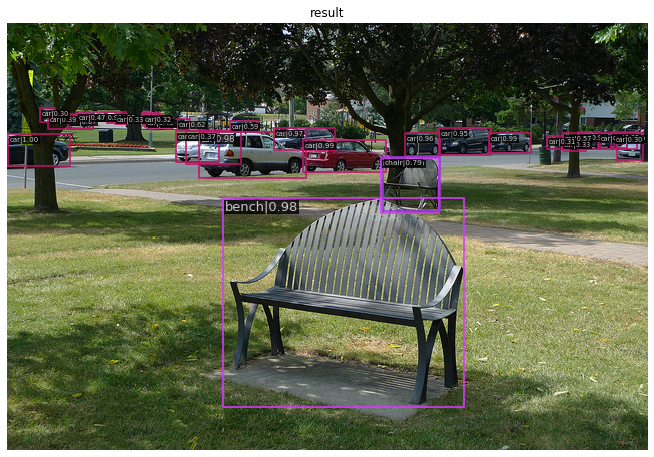

In [10]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

# Train A Detector on A Customized Dataset
To train a new detector, there are usually three things to do:

Support a new dataset
Modify the config
Train a new detector
Support a new dataset
There are three ways to support a new dataset in MMDetection:

Reorganize the dataset into a COCO format.
Reorganize the dataset into a middle format.
Implement a new dataset.
We recommend the first two methods, as they are usually easier than the third one.

In this tutorial, we give an example that converts the data into the formats of existing datasets, e.g. COCO, VOC, etc. Other methods and more advanced usages can be found in the doc.

First, let's download a tiny dataset obtained from KITTI. We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but with 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of the dataset.